## Setting Up

In [1]:
# Turn on inline display of plots in the notebook. (We should work on a more
# portable solution such as saving th plots to files down the road.)
%matplotlib inline

In [1]:
import pyodbc

#### Create a connection function

In [2]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;') # Windows auth
        return connection
    except:
        return 1 # could not connect

In [3]:
import pandas as pd

## Visualizing [DataCells].[DurationSeconds]

In [4]:
# Connect to [Interject_Reporting]:
# intj_reporting_df = pd.read_sql('[DataCells].[Request]', engine)

reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

In [5]:
# Create a cursor to run straight SQL queries:
# reporting_cursor = reporting_conn.cursor()

In [6]:
# Load [DataCells].[Request] and [DataCells].[Request_History] into DataFrames:
request = 'SELECT * FROM [DataCells].[Request]'  # Don't need * here...
request_history = 'SELECT * FROM [DataCells].[Request_History]'
request_df = pd.read_sql(request, reporting_conn) # So we don't need SQLalchemy...
request_history_df = pd.read_sql(request_history, reporting_conn) # So we don't need SQLalchemy...

[DataCells].[DurationSeconds] includes negative values for some reason... their absolute values are accurate, but just have a - in front of them...

In [7]:
request_df['DurationSeconds'].describe()

count    281.000000
mean       5.039146
std       60.829051
min      -10.000000
25%       -2.000000
50%       -1.000000
75%        0.000000
max      984.000000
Name: DurationSeconds, dtype: float64

In [8]:
# Histogram of DurationSeconds:
request_df.hist(column='DurationSeconds')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x04FBFF50>]],
      dtype=object)

## Visualizing request time durations manually (StartTimeStamp - EndTimeStamp)

Create a pd series that is ( StartTimeStamp - EndTimeStamp ). Doing this to resolve the negative DurationSeconds values reported above...

#### Setting Up

In [9]:
# Define a function that we can use with both [DataCells].[Request] and .[Request_History]
def get_request_time_durations(table_name):
    start_end_diff = 'SELECT datediff(second, [StartTimeStamp], [EndTimeStamp]) as StartEndDiffSeconds FROM [DataCells].[' + table_name + ']'
    return( pd.read_sql(start_end_diff, reporting_conn) )

    # # Do it with a cursor:
    # reporting_cursor.execute(start_end_diff_sql)
    # request_durations = pd.Series(reporting_cursor.fetchall())

In [10]:
request_durations = get_request_time_durations('Request')
request_history_durations = get_request_time_durations('Request_History')

#### Get some initial counts

How many data do we have for request durations in [Request] and [Request_History]?

In [11]:
request_durations.count()

StartEndDiffSeconds    281
dtype: int64

In [12]:
request_history_durations.count()

StartEndDiffSeconds    7417
dtype: int64


How many entries are NAN (not included in the previous counts)?

In [13]:
request_durations.isna().sum()

StartEndDiffSeconds    60
dtype: int64

In [14]:
request_history_durations.isna().sum()

StartEndDiffSeconds    67
dtype: int64

#### Describe Duration Data

In [15]:
request_durations.describe() 

,StartEndDiffSeconds
count,281.000000
mean,7.825623
std,60.532059
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,984.000000


In [16]:
request_history_durations.describe()

,StartEndDiffSeconds
count,7.417000e+03
mean,3.146081e+02
std,2.532012e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.178484e+06


#### Plot query run time distributions using pd.unique() and pd.value_counts()

Find unique values and their frequencies, plot the distributions.

In [17]:
request_durations.shape

(341, 1)

In [18]:
request_durations.T.shape

(1, 341)

In [25]:
# 1D-ify them (should become series'):
request_durations_series = request_durations.squeeze()
request_history_durations_series = request_history_durations.squeeze()
print(request_durations_series.shape)
print(request_history_durations_series.shape)

type(request_durations_series) is pd.Series

# Didn't work...
# request_durations_arr = request_durations.values
# request_durations_arr.shape
# request_durations_series = pd.Series(request_durations_arr)

(341,)
(7484,)


True

In [28]:
# Save unique values:
request_unique_durs = request_durations_series.unique()
request_history_unique_durs = request_history_durations_series.unique()

print('[Request] unique time values: ')
print(request_unique_durs)
print('\n[Request_History] unique time values: ')
print(request_history_unique_durs)

[Request] unique time values: 
[  0.  12.  13.   9.   8.   1.   5.  11.  31.  27. 187. 180.  nan  24.
 984.  20.   2.   3.   4.   7.   6.]

[Request_History] unique time values: 
[0.000000e+00 1.000000e+00 4.000000e+00 3.000000e+00 4.600000e+01
 2.000000e+00 5.000000e+00          nan 8.000000e+00 6.000000e+00
 7.000000e+00 1.800000e+01 1.700000e+01 6.200000e+01 7.200000e+01
 1.100000e+01 1.980000e+02 2.000000e+01 1.600000e+01 1.900000e+01
 2.300000e+01 9.485300e+04 4.920000e+02 1.500000e+01 1.400000e+01
 1.200000e+01 9.000000e+00 4.000000e+01 2.200000e+01 2.100000e+01
 1.028400e+04 1.067300e+04 1.057100e+04 7.866000e+03 6.110000e+02
 6.090000e+02 6.390000e+02 6.520000e+02 2.400000e+01 3.130000e+02
 2.700000e+01 2.900000e+01 2.500000e+01 6.300000e+01 6.000000e+01
 1.720000e+02 6.100000e+01 6.600000e+01 6.400000e+01 3.660000e+02
 3.600000e+02 1.850000e+02 1.840000e+02 1.210000e+02 7.100000e+01
 7.600000e+01 7.800000e+01 7.700000e+01 7.500000e+01 1.450000e+02
 6.800000e+01 7.900000e+01 9.

In [30]:
# Get the frequencies for each unique duration:
request_dur_freq = request_durations_series.value_counts(dropna=False)
request_dur_freq

1.0      95
NaN      60
0.0      54
3.0      29
2.0      22
5.0      19
4.0      15
9.0      15
6.0       7
8.0       5
7.0       4
12.0      4
11.0      2
24.0      2
13.0      2
180.0     1
27.0      1
31.0      1
984.0     1
20.0      1
187.0     1
Name: StartEndDiffSeconds, dtype: int64

In [52]:
type(request_dur_freq) is pd.Series

True

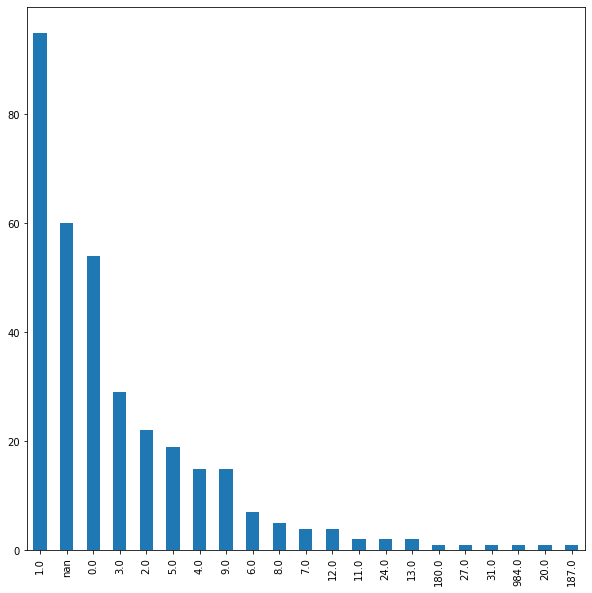

In [32]:
request_dur_freq.plot.bar(figsize=(10,10))

In [33]:
# request_dur_freq.hist(figsize=(10,30), bins=[1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,150,200])

In [ ]:
request_history_dur_freq = request_history_durations_series.value_counts(dropna=False)
request_history_dur_freq

#### Try Astropy histrograms on large, non-normalized data set

In [36]:
import astropy.visualization as astv, astropy.stats as asts, scipy, numpy as np

In [ ]:
# On all data (request_history_durations_series):
request_history_durs_arr = pd.Series.to_numpy(request_history_durations_series)
print(request_history_durs_arr)
astv.hist(request_history_durs_arr, bins='blocks')

In [ ]:
request_history_freq_arr = pd.Series.to_numpy(request_history_dur_freq)
print(request_history_durs_arr)
astv.hist(request_history_freq_arr, bins='blocks')

In [39]:
# request_history_durations_arr = pd.Series.to_numpy(request_history_durations_series.T)
# print(request_history_durations_arr)
# request_history_time_freq_arr = pd.Series.to_numpy(request_history_time_freq)
# bins = asts.bayesian_blocks(request_history_durations_arr)
count, div = np.histogram(request_history_durations.dropna())
print(div)

[      0.   217848.4  435696.8  653545.2  871393.6 1089242.  1307090.4
 1524938.8 1742787.2 1960635.6 2178484. ]


In [ ]:
request_history_durations.dropna().hist(bins=div, figsize=(20,20))

In [ ]:
request_history_dur_freq.hist(bins="bins", figsize=(20,20))

In [ ]:
request_history_durations.plot.hist(figsize=(20,20), bins=[-1,100,200,20000000])

In [ ]:
request_history_dur_freq.plot.bar(figsize=(20,100))

## Prep data for vizualizing request durations as by occurance time

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#### Get the data

In [5]:
reporting_conn_2 = pyodbc_connect_scotty_test('Interject_Reporting')

In [6]:
# Select [EndTimeStamp] to mark the day, [Duration], from [Request] union with [Request_History] w/ SQL:
from_req = 'SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request]'
union = ' UNION ALL'
from_req_hist = ' SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request_History]'
sql = from_req + union + from_req_hist
all_requests = pd.read_sql(sql, reporting_conn_2, index_col='StartTimeStamp')

In [7]:
type(all_requests) is pd.DataFrame

True

#### Initial counts

In [8]:
all_requests.head()

,Duration
StartTimeStamp,
2015-05-30 21:23:56.030,0.0
2015-05-30 23:36:55.653,12.0
2015-05-30 23:38:25.200,13.0
2015-05-30 23:44:01.490,9.0
2015-05-30 23:51:05.340,8.0


In [9]:
all_requests.isna().sum()

Duration    127
dtype: int64

In [10]:
all_requests.isna().sum()

Duration    127
dtype: int64

In [12]:
# Note: Resampler objects are returned by .resample() calls. Will not work until set index to EndTimeStamp!
# dur_by_day_resampler = all_requests_s.resample('D')
# max_dur_by_day_resampler = all_requests_s.resample('D').max()

#### Create basis DFs containing all historical requests

In [11]:
all_requests['Year'] = all_requests.index.year
all_requests['Month'] = all_requests.index.month
all_requests['Week'] = all_requests.index.week
all_requests['Day'] = all_requests.index.day
all_requests = all_requests.dropna()
all_requests.head()

,Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-05-30 21:23:56.030,0.0,2015,5,22,30
2015-05-30 23:36:55.653,12.0,2015,5,22,30
2015-05-30 23:38:25.200,13.0,2015,5,22,30
2015-05-30 23:44:01.490,9.0,2015,5,22,30
2015-05-30 23:51:05.340,8.0,2015,5,22,30


#### Create DF grouped by day w/ max request duration per day

Create new DataFrame with max request duration for day, + time bucket columns:

In [12]:
# Create daily_max_request DF by downsampling all_requests_df:
daily_max_request = all_requests.resample('D').max()
daily_max_request['Year'] = daily_max_request.index.year
daily_max_request['Month'] = daily_max_request.index.month
daily_max_request['Weekday'] = daily_max_request.index.weekday_name
daily_max_request = daily_max_request.dropna()
daily_max_request = daily_max_request.rename(columns={'Duration':'Max_Duration'})
daily_max_request.head()

# week_groups = daily_max_request.groupby([pd.Grouper(freq='W'), 'Duration'])
# weeks = pd.DataFrame()
# for dur, week in week_groups:
#     week_groups[week.dur] = week.values

# all_requests_df['day'] = all_requests_df.index.day
# all_requests_df['week'] = all_requests_df.index.week

,Max_Duration,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-01-19,4.0,2015,1,4.0,19.0,Monday
2015-01-22,1.0,2015,1,4.0,22.0,Thursday
2015-01-26,46.0,2015,1,5.0,26.0,Monday
2015-01-27,2.0,2015,1,5.0,27.0,Tuesday
2015-01-28,5.0,2015,1,5.0,28.0,Wednesday


In [13]:
# Create a DF for each month:

# def create_df_for_month(origin_df, month_df, month_num): # Can python modify objects passed to it?
#     for i in range(len(all_requests_df['Month'])): # 'Month' to be more readable/explicit
#         if all_requests['Month'][i] = 1:
#             month_df['Month'][i] = 

## Playing around with pure matplotlib...

Get a feel for object-oriented approach in matplotlib

#### Plot max request durations by day

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=daily_max_request.Weekday, y=daily_max_request.Max_Duration)
#ax.hist((daily_max_request.weekday))

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,10))  # Alternatively, use axes array: ax[4]

# Create the scatter plot for the first week:
ax1.scatter(x=daily_max_request.Weekday, y=daily_max_request.Max_Duration)

In [ ]:
# Use matplotlib object oriented approach to create a plot by day:

# Remove index...

request_days_arr = all_requests_df.day.values # Convert Series to nd array (transpose the matrix first)
print()
#print(all_requests_arr[0])  # Debugging
# Convert Timestamp data (EndTimeStamp) to datetime:
#for i in range(len(all_requests_arr[0])):
#        all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
       # all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
#print(all_requests_arr[0])  # Debugging

fig, ax = plt.subplots()
ax.hist(all_requests_arr)

In [ ]:
# Check time data types:
print(all_requests_df)
print(durations_by_day)

In [ ]:
weeks = pd.DataFrame()

for day in durations_by_day.count():
    weeks[i] = 


for index, max_dur in durations_by_day:
    weeks[index] = max_dur.values
weeks.plot(subplots=True, legend=False)
plt.show()

## Seaborn for visualizing request durations by time occurred

In [15]:
import seaborn as sns

Add Y, M, W, D columns to all_requests for easy plotting by *occurance time* later. This will be our basis DF for many others.

#### Daily max request durations by weekday

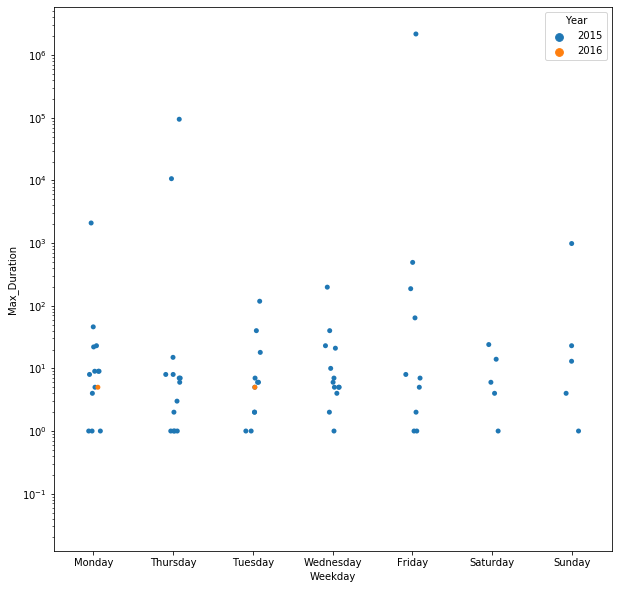

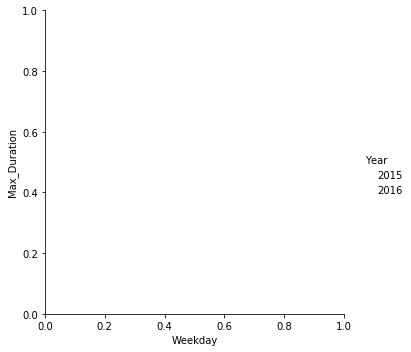

In [31]:
#--- Why do we have two graphs showing up here?
fig, ax = plt.subplots(figsize=(10,10))
ax.set(yscale='log')
sns.catplot(x='Weekday', y='Max_Duration', hue='Year', data=daily_max_request, ax=ax)
plt.show()

# Day of the month instead of week, exclude sat/sun. Should see a pattern of spikes for first 7 day of the month.

# Add another variable, count of durations. Plot with amount of calls, overlay durations.

#### Durations by month

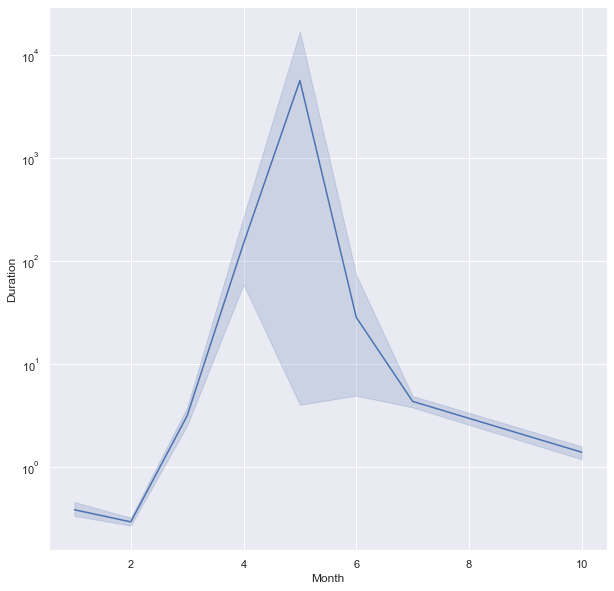

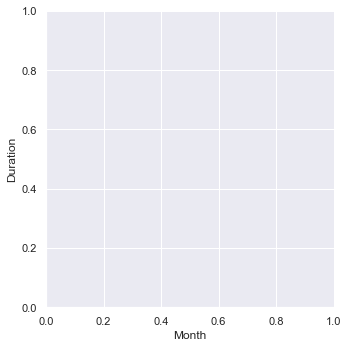

In [165]:
fig_dm, ax_dm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_dm.set(yscale='log')
sns.relplot(x='Month', y='Duration', data=all_requests, ax=ax_dm, kind='line')

#### Create DF for all_requests for each month

Group and split all_requests data by month

In [ ]:
# Hanlde these errors. Handle errors for nulls in all of the code.

In [225]:
grouped_months = all_requests.groupby('Month')
# for name, group in grouped_months:
#     print(name)
#     print(group)

# Some months have no data, exclude these:
all_requests_jan = grouped_months.get_group(1)
all_requests_feb = grouped_months.get_group(2)
all_requests_mar = grouped_months.get_group(3)
all_requests_apr = grouped_months.get_group(4)
all_requests_may = grouped_months.get_group(5)
all_requests_jun = grouped_months.get_group(6)
all_requests_jul = grouped_months.get_group(7)
#all_requests_aug = grouped_months.get_group(8)
# all_requests_sep = grouped_months.get_group(9)
all_requests_oct = grouped_months.get_group(10)
# all_requests_nov = grouped_months.get_group(11)
# all_requests_dec = grouped_months.get_group(12)

#### Durations Jan

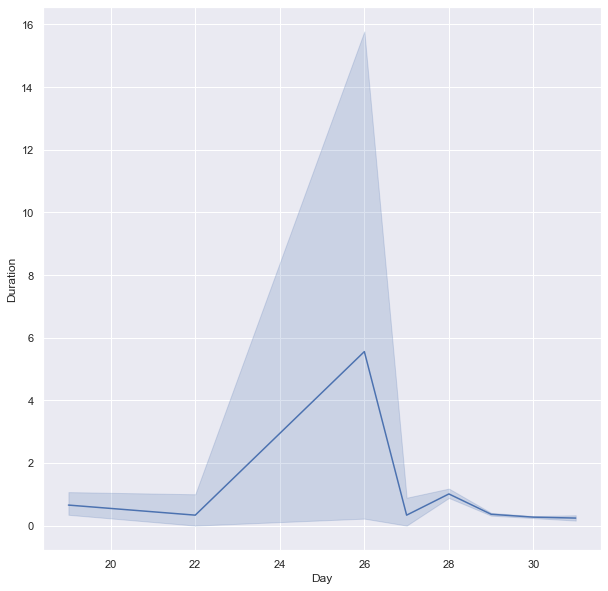

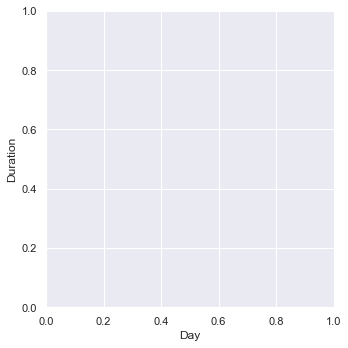

In [105]:
fig_j, ax_j = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
sns.relplot(x='Day', y='Duration', data=all_requests_jan, ax=ax_j, kind='line')

#### Durations by day of the month

In [ ]:
# Make labels readable. Exclude weekends. Exclude holidays? Make if very obvious that we are excluding thesedays, make this reversible.

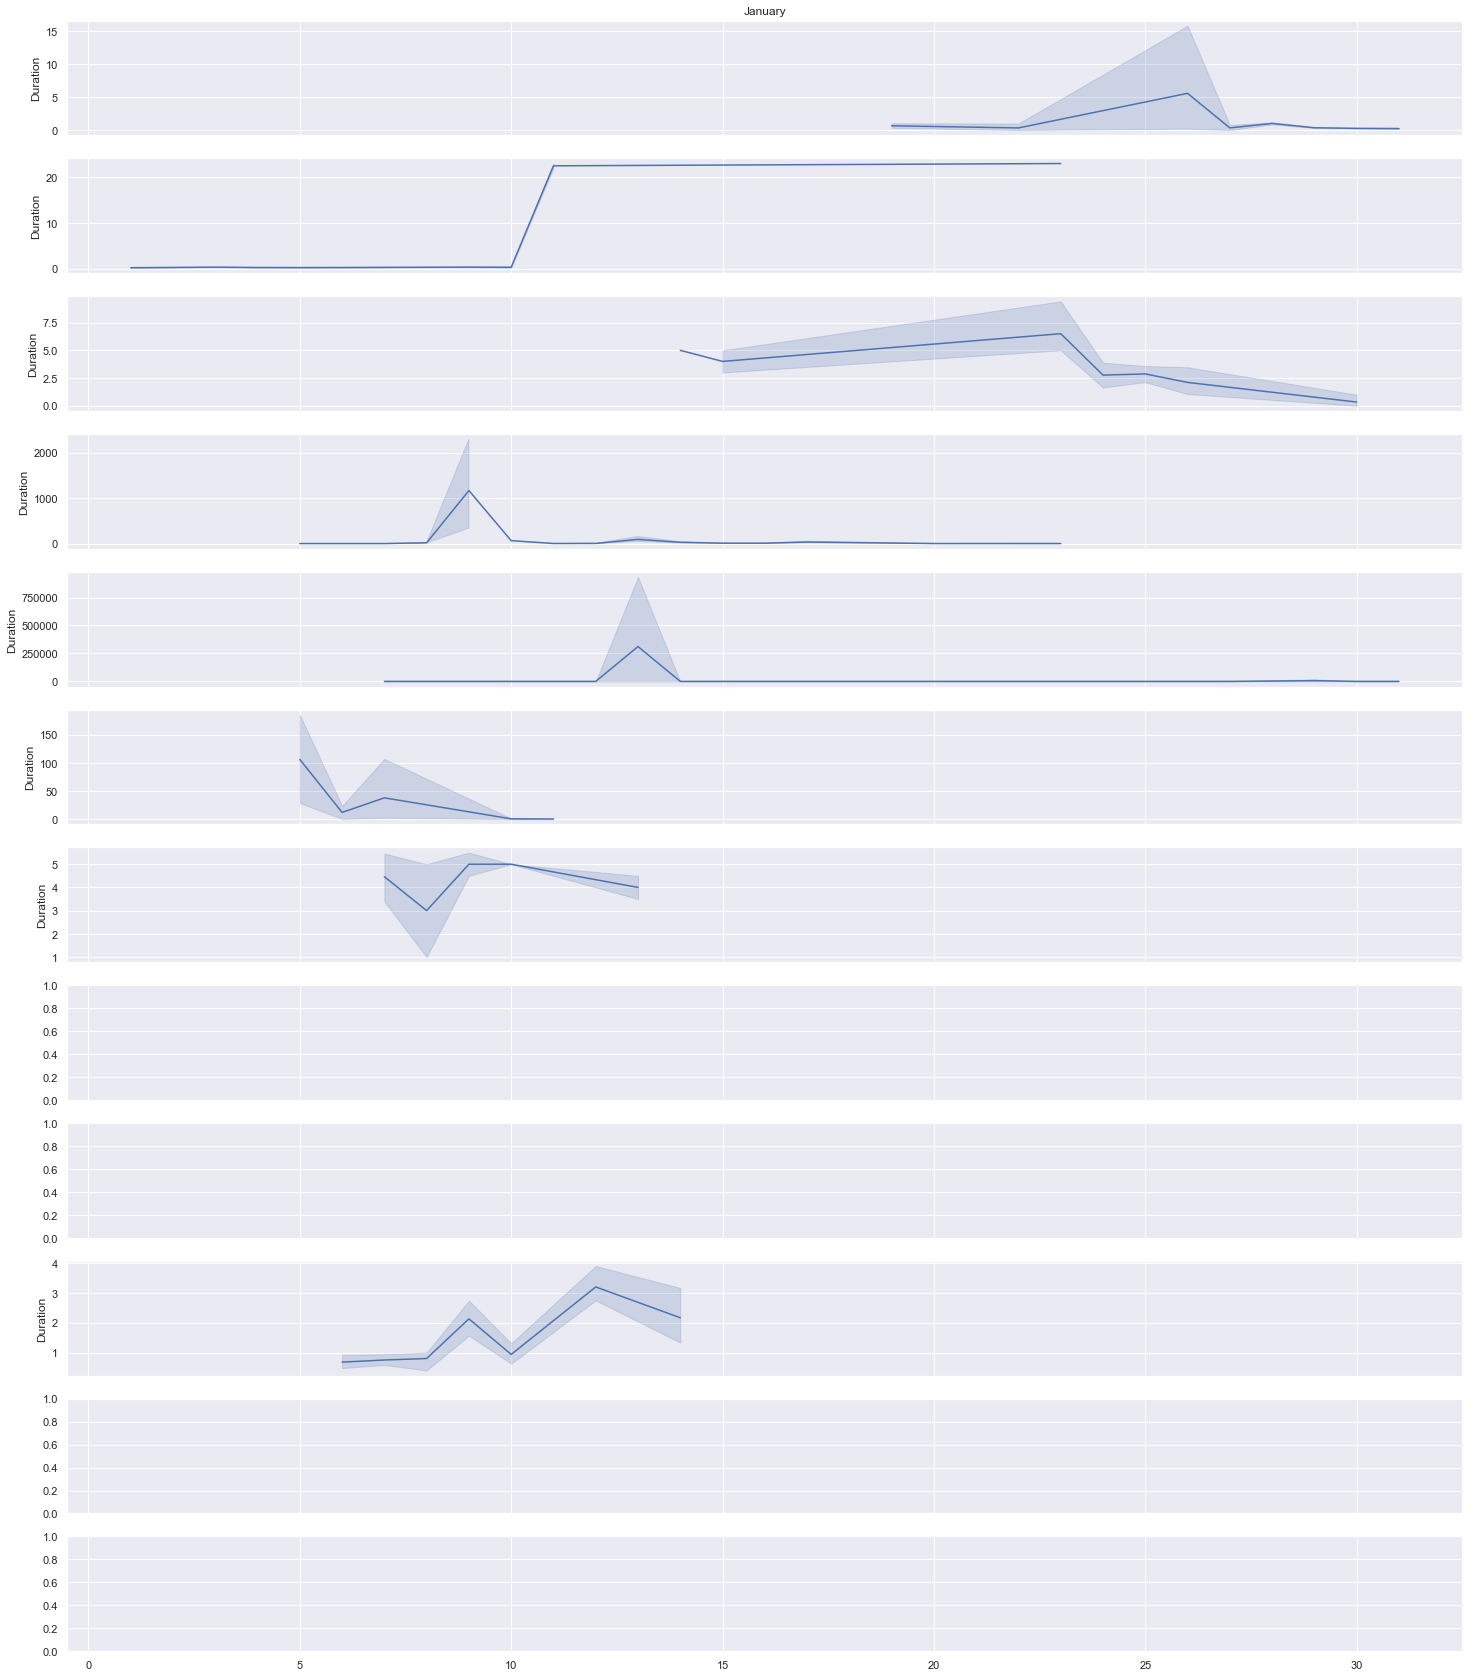

In [226]:
#--- Make this more concise?
fig_months, axes = plt.subplots(12, 1, figsize=(25,30), sharex='all')
sns.lineplot(x='Day', y='Duration', data=all_requests_jan, ax=axes[0]).set(title="January")
sns.lineplot(x='Day', y='Duration', data=all_requests_feb, ax=axes[1])
sns.lineplot(x='Day', y='Duration', data=all_requests_mar, ax=axes[2])
sns.lineplot(x='Day', y='Duration', data=all_requests_apr, ax=axes[3])
sns.lineplot(x='Day', y='Duration', data=all_requests_may, ax=axes[4])
sns.lineplot(x='Day', y='Duration', data=all_requests_jun, ax=axes[5])
sns.lineplot(x='Day', y='Duration', data=all_requests_jul, ax=axes[6])
#sns.lineplot(x='Day', y='Duration', data=all_requests_aug, ax=axes[7])
#sns.lineplot(x='Day', y='Duration', data=all_requests_sep, ax=axes[8])
sns.lineplot(x='Day', y='Duration', data=all_requests_oct, ax=axes[9])
#sns.lineplot(x='Day', y='Duration', data=all_requests_nov, ax=axes[10])
#sns.lineplot(x='Day', y='Duration', data=all_requests_dec, ax=axes[11])`

#### Request load by month

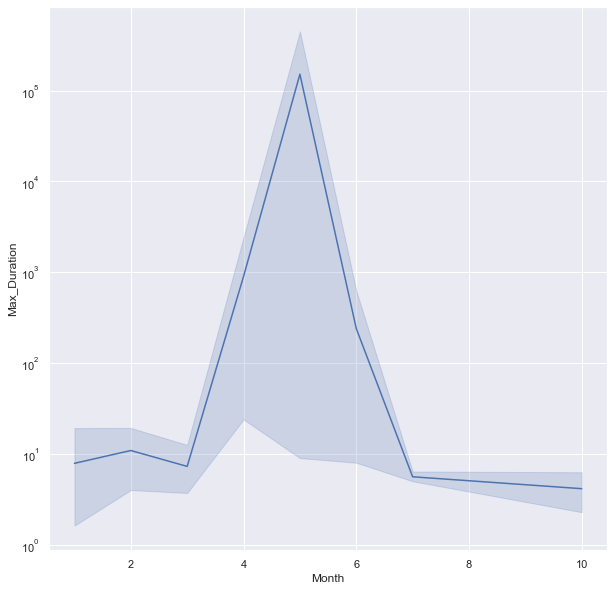

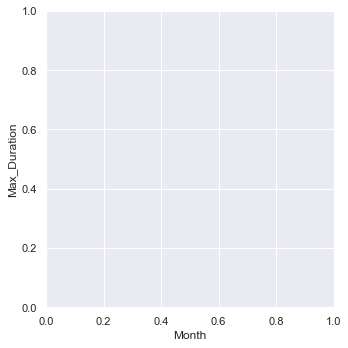

In [166]:
fig_lm, ax_lm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_lm.set(yscale='log')
sns.relplot(x='Month', y='Max_Duration', data=daily_max_request, ax=ax_lm, kind='line')

#### Min/max request dur. per week vs. request load per day

Create new DF with total requests per day:

In [23]:
# Modify this to . Don't necessarily care about days. Collapse into 5 day (M=F) increments and repeat these over each month.
# Summarize average request time but overlay min and max/outliers.
# Use log scale with infinite deviation (for requests so long that something is wrong with the server)/cutoff point for extreme outliers.
# Three months of data for week view. Maybe month-by-month for 2 years. Total health history for all data.
# Make these time variables easy to modify by new users of this notebook.

# We will be giving this to clients. This will be a way to diagnose issues. This notebook will be logs, there wil be another for troubleshooting server issues.

# Might be able to get new data to test (WCN has 5 yrs).

# Prefer mean over average.

In [14]:
daily_request_count = all_requests.resample('D').count()
daily_request_count['Month'] = daily_request_count.index.month
daily_request_count['Weekday'] = daily_request_count.index.weekday_name
daily_request_count = daily_request_count.dropna()
daily_request_count = daily_request_count.rename(columns={'Duration':'Duration_Count'})
daily_request_count.head()

,Duration_Count,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-01-19,29,29,1,29,29,Monday
2015-01-20,0,0,1,0,0,Tuesday
2015-01-21,0,0,1,0,0,Wednesday
2015-01-22,3,3,1,3,3,Thursday
2015-01-23,0,0,1,0,0,Friday


Create DF with maxes/mins per week:

In [216]:
# First get maxes into a new DF with week downsample:
request_max_wk = all_requests.resample('W').max()
#request_max_wk = request_max_wk.rename(columns={'Duration':'Max_Duration'})

# Then get mins into a new DF:
# request_min_wk = all_requests.resample('W').min()
# request_min_wk = request_min_wk.rename(columns={'Duration':'Min_Duration'})

# Create an outliers DF with both max and min:
request_outliers_wk = all_requests.resample('W').min()
request_outliers_wk['Weekday'] = request_outliers_wk.index.weekday_name
request_outliers_wk['Max_Duration'] = request_max_wk['Duration']
request_outliers_wk = request_outliers_wk.rename(columns={'Duration':'Min_Duration'})
request_outliers_wk = request_outliers_wk.dropna()
request_outliers_wk.head()

,Min_Duration,Year,Month,Week,Day,Weekday,Max_Duration
EndTimeStamp,,,,,,,
2015-01-25,0.0,2015.0,1.0,4.0,19.0,Sunday,4.0
2015-02-01,0.0,2015.0,1.0,5.0,1.0,Sunday,46.0
2015-02-08,0.0,2015.0,2.0,6.0,2.0,Sunday,40.0
2015-02-15,0.0,2015.0,2.0,7.0,9.0,Sunday,23.0
2015-03-01,23.0,2015.0,2.0,9.0,23.0,Sunday,23.0


## 3-month historical log for M-F weeks

Consider eliminating months that we don't need in sql...

In [52]:
# Definitons:
start_month = 3
end_month = 6
year = 2015

Select only the months and year specified

In [53]:
month_filter = ( (all_requests['Month'] >= start_month) & (all_requests['Month'] <= end_month) & (all_requests['Year'] == year) ) # Boolean series
history_3_mon = all_requests.where(month_filter)
history_3_mon = history_3_mon.dropna()
history_3_mon.head()

,Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-05-30 21:23:56.030,0.0,2015.0,5.0,22.0,30.0
2015-05-30 23:36:55.653,12.0,2015.0,5.0,22.0,30.0
2015-05-30 23:38:25.200,13.0,2015.0,5.0,22.0,30.0
2015-05-30 23:44:01.490,9.0,2015.0,5.0,22.0,30.0
2015-05-30 23:51:05.340,8.0,2015.0,5.0,22.0,30.0


Drop Sunday and Saturday:

In [154]:
# Add Weekday col:
history_3_mon['Weekday'] = history_3_mon.index.weekday_name

weekday_filter = ( (history_3_mon['Weekday'] != 'Saturday') & (history_3_mon['Weekday'] != 'Sunday') )
history_3_mon = history_3_mon.where(weekday_filter)
history_3_mon = history_3_mon.dropna()
history_3_mon

,Duration,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-06-05 17:12:25.463,31.0,2015.0,6.0,23.0,5.0,Friday
2015-06-05 17:13:13.413,27.0,2015.0,6.0,23.0,5.0,Friday
2015-06-05 17:14:33.830,187.0,2015.0,6.0,23.0,5.0,Friday
2015-06-05 17:22:08.527,180.0,2015.0,6.0,23.0,5.0,Friday
2015-06-10 20:57:54.977,5.0,2015.0,6.0,24.0,10.0,Wednesday
2015-06-10 21:04:22.207,2.0,2015.0,6.0,24.0,10.0,Wednesday
2015-06-10 21:05:39.840,2.0,2015.0,6.0,24.0,10.0,Wednesday
2015-06-10 21:08:55.590,1.0,2015.0,6.0,24.0,10.0,Wednesday
2015-06-10 22:10:44.173,0.0,2015.0,6.0,24.0,10.0,Wednesday


Find mins/maxes for weeks:

In [55]:
# Pull out only the data we need from all_requests here:
# all_request_durs = all_requests['Duration']
# all_request_durs['Weekday'] = all_requests.index.weekday_name
# all_request_durs.head()

#### 3-month historical stats by WEEK

##### Create 2 DFs, one w/ *most* aggs. for the week, one preserving other columns, then join

Idea for this approach:

In [56]:
# Need to preserve just the Week by using it as an index, then make another aggregated dataframe by week with
# all the columns then merge them on Week number.

1st DF - all aggregations by week that we need to do (except for mean)...

In [151]:
week_aggs = history_3_mon.groupby('Week', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
)
week_aggs

,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day
Week,,,,,
13.0,0.0,22.0,87,23.0,26.0
14.0,0.0,1.0,3,30.0,30.0
15.0,0.0,10673.0,85,6.0,10.0
16.0,0.0,2178484.0,218,13.0,17.0
17.0,0.0,8.0,16,20.0,23.0
19.0,0.0,8.0,8,7.0,7.0
20.0,0.0,40.0,84,12.0,15.0
21.0,0.0,8.0,222,18.0,22.0
22.0,0.0,94853.0,41,26.0,29.0


2nd DF - one aggregation w/ df.resample() to preserve other columns:

In [152]:
# Downsample history_3_mon to keep its datetime index
week_agg_mean = history_3_mon.resample('W').mean()
week_agg_mean = week_agg_mean.rename(columns={'Duration':'Mean_Duration'})
week_agg_mean.dropna(inplace=True) # use this form elsewhere!
week_agg_mean

,Mean_Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-03-29,3.183908,2015.0,3.0,13.0,24.747126
2015-04-05,0.333333,2015.0,3.0,14.0,30.000000
2015-04-12,510.458824,2015.0,4.0,15.0,7.717647
2015-04-19,10049.894495,2015.0,4.0,16.0,14.912844
2015-04-26,0.875000,2015.0,4.0,17.0,22.625000
2015-05-10,1.500000,2015.0,5.0,19.0,7.000000
2015-05-17,1.357143,2015.0,5.0,20.0,14.107143
2015-05-24,2.644144,2015.0,5.0,21.0,20.788288
2015-05-31,2341.317073,2015.0,5.0,22.0,27.560976


Join the two

In [65]:
dur_stats_3_mon_by_wk = pd.merge(week_aggs, week_agg_mean, on='Week')
dur_stats_3_mon_by_wk['Year-Month'] = dur_stats_3_mon_by_wk['Year'].astype(int).astype(str) + '/' + dur_stats_3_mon_by_wk['Month'].astype(int).astype(str) + '\ndays: ' + dur_stats_3_mon_by_wk['First_Day'].astype(int).astype(str) + '-' + dur_stats_3_mon_by_wk['Last_Day'].astype(int).astype(str)
dur_stats_3_mon_by_wk

,Week,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day,Mean_Duration,Year,Month,Day,Year-Month
0,13.0,0.0,22.0,87,23.0,26.0,3.183908,2015.0,3.0,24.747126,2015/3\ndays: 23-26
1,14.0,0.0,1.0,3,30.0,30.0,0.333333,2015.0,3.0,30.000000,2015/3\ndays: 30-30
2,15.0,0.0,10673.0,85,6.0,10.0,510.458824,2015.0,4.0,7.717647,2015/4\ndays: 6-10
3,16.0,0.0,2178484.0,218,13.0,17.0,10049.894495,2015.0,4.0,14.912844,2015/4\ndays: 13-17
4,17.0,0.0,8.0,16,20.0,23.0,0.875000,2015.0,4.0,22.625000,2015/4\ndays: 20-23
5,19.0,0.0,8.0,8,7.0,7.0,1.500000,2015.0,5.0,7.000000,2015/5\ndays: 7-7
6,20.0,0.0,40.0,84,12.0,15.0,1.357143,2015.0,5.0,14.107143,2015/5\ndays: 12-15
7,21.0,0.0,8.0,222,18.0,22.0,2.644144,2015.0,5.0,20.788288,2015/5\ndays: 18-22
8,22.0,0.0,94853.0,41,26.0,29.0,2341.317073,2015.0,5.0,27.560976,2015/5\ndays: 26-29
9,23.0,27.0,187.0,4,5.0,5.0,106.250000,2015.0,6.0,5.000000,2015/6\ndays: 5-5


finally...

#### Convert to long-form to use categorical functionality of sns.swarmplot

In [66]:
# Unpivot:
longform_dur_stats_3_mon_by_wk = pd.melt(dur_stats_3_mon_by_wk, id_vars='Week', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
longform_dur_stats_3_mon_by_wk = pd.merge(longform_dur_stats_3_mon_by_wk, dur_stats_3_mon_by_wk, how='left', on='Week')
longform_dur_stats_3_mon_by_wk.head()

,Week,Dur_Stat_Type,Dur_Stat_Value,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day,Mean_Duration,Year,Month,Day,Year-Month
0,13.0,Min_Duration,0.0,0.0,22.0,87,23.0,26.0,3.183908,2015.0,3.0,24.747126,2015/3\ndays: 23-26
1,14.0,Min_Duration,0.0,0.0,1.0,3,30.0,30.0,0.333333,2015.0,3.0,30.000000,2015/3\ndays: 30-30
2,15.0,Min_Duration,0.0,0.0,10673.0,85,6.0,10.0,510.458824,2015.0,4.0,7.717647,2015/4\ndays: 6-10
3,16.0,Min_Duration,0.0,0.0,2178484.0,218,13.0,17.0,10049.894495,2015.0,4.0,14.912844,2015/4\ndays: 13-17
4,17.0,Min_Duration,0.0,0.0,8.0,16,20.0,23.0,0.875000,2015.0,4.0,22.625000,2015/4\ndays: 20-23


#### Plots of stats for 3 months, by week

In [67]:
import seaborn as sns

##### Swarmplot of min, max, mean, count w/ lin-reg fit

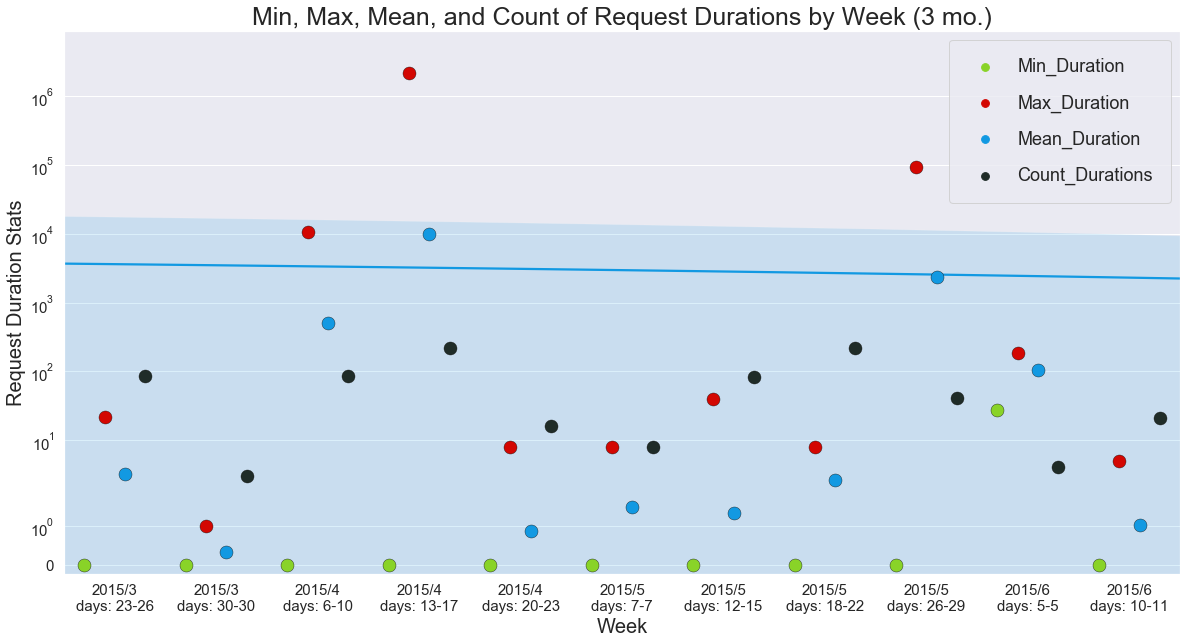

In [72]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

colors = sns.color_palette(('#89D328', '#D30702', '#1299E2', '#1F2C28'))  # MIN, MAX, MEAN, COUNT

sns.swarmplot(x='Week', y='Dur_Stat_Value', hue='Dur_Stat_Type', data=longform_dur_stats_3_mon_by_wk, dodge=True, edgecolor='gray', linewidth=.4, palette=colors, s=13, ax=ax)
sns.regplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, color='#1299E2', scatter_kws={'s': 0}, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Week', fontsize=20)
ax.set_title('Min, Max, Mean, and Count of Request Durations by Week (3 mo.)', loc='center', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(longform_dur_stats_3_mon_by_wk['Year-Month'])

ax.legend(borderpad=1, labelspacing=1, fontsize=18)

##### Lineplot of MEAN, with counts for each week

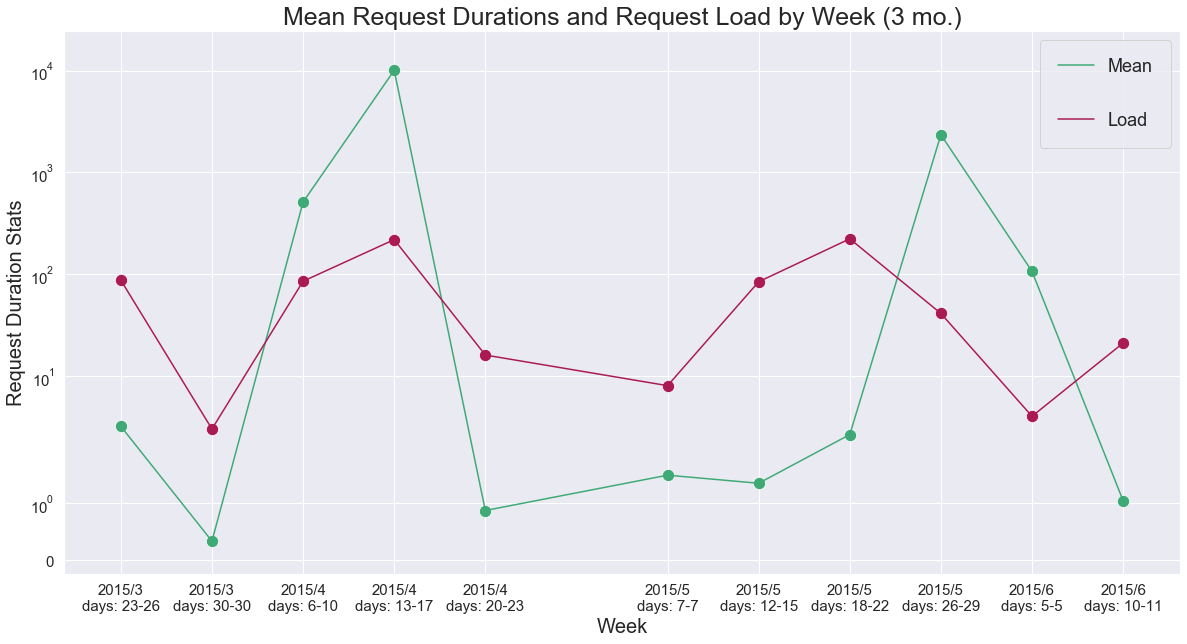

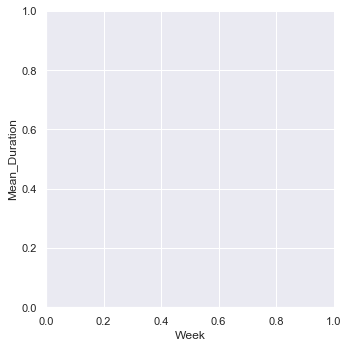

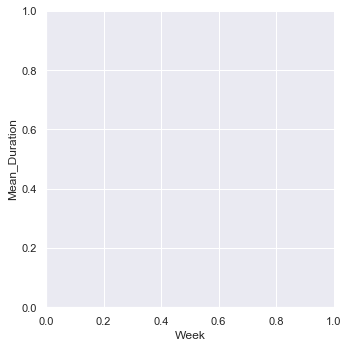

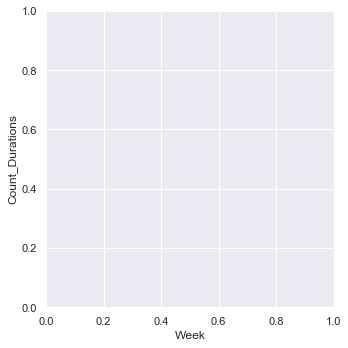

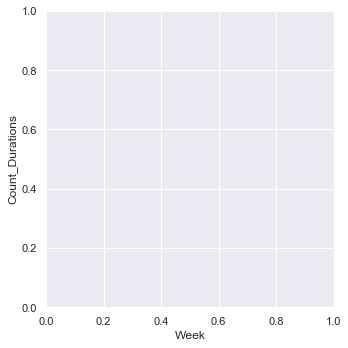

In [141]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

# nice green: #3FAA75
sns.relplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, kind='line', color='#3FAA75', ax=ax)
sns.relplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, kind='scatter', color='#3FAA75', s=150, ax=ax)
sns.relplot(x='Week', y='Count_Durations', data=dur_stats_3_mon_by_wk, kind='line', color='#AB1B53', ax=ax)
sns.relplot(x='Week', y='Count_Durations', data=dur_stats_3_mon_by_wk, kind='scatter', color='#AB1B53', s=150, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Week', fontsize=20)

ax.set_title('Mean Request Durations and Request Load by Week (3 mo.)', loc='center', fontsize=25)

ax.set_xticks(dur_stats_3_mon_by_wk['Week'])
ax.set_xticklabels(longform_dur_stats_3_mon_by_wk['Year-Month'])
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(('Mean', 'Load'), borderpad=1, labelspacing=2, fontsize=18)

#### 3-month historical stats by DAY

In [148]:
day_aggs = history_3_mon.groupby('Day', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count')
)
day_aggs

,Min_Duration,Max_Duration,Count_Durations
0,27.0,187.0,4
1,0.0,1.0,23
2,0.0,8.0,25
3,0.0,21.0,7
4,1.0,10673.0,37
5,0.0,64.0,16
6,0.0,1.0,6
7,0.0,6.0,2
8,0.0,2094.0,101
9,0.0,118.0,76


In [153]:
day_agg_mean = history_3_mon.resample('D').mean()
day_agg_mean = day_agg_mean.rename(columns={'Duration':'Mean_Duration'})
# day_agg_mean.dropna(inplace=True) # use this form elsewhere!
day_agg_mean

,Mean_Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-03-23,6.500000,2015.0,3.0,13.0,23.0
2015-03-24,2.764706,2015.0,3.0,13.0,24.0
2015-03-25,2.871795,2015.0,3.0,13.0,25.0
2015-03-26,2.105263,2015.0,3.0,13.0,26.0
2015-03-27,NaN,NaN,NaN,NaN,NaN
2015-03-28,NaN,NaN,NaN,NaN,NaN
2015-03-29,NaN,NaN,NaN,NaN,NaN
2015-03-30,0.333333,2015.0,3.0,14.0,30.0
2015-03-31,NaN,NaN,NaN,NaN,NaN
